# IMRPhenomD test

## Example of NaN

In [65]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from ripple.waveforms import IMRPhenomD
import matplotlib.pyplot as plt
from ripple import ms_to_Mc_eta
from ripple.constants import MSUN, gt
from jax import grad, vmap
from functools import partial
jax.config.update("jax_enable_x64", True)

params = {"axes.grid": True,
          "text.usetex" : True,
          "font.family" : "serif",
          "ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16,
          "figure.titlesize": 16}

plt.rcParams.update(params)

In [47]:
# Some very specific number for mass, for which NaN was observed
m = 2.212299314305308 # mass in solar masses
m1 = m
m2 = m

chi = 0.0 # z-component spin
chi1 = chi 
chi2 = chi

In [48]:
tc = 0.0 # Time of coalescence in seconds
phic = 0.0 # Time of coalescence
dist_mpc = 440 # Distance to source in Mpc
inclination = 0.0 # Inclination Angle
polarization_angle = 0.2 # Polarization angle

# Generate frequency grid
f_l = 24
f_u = 512
del_f = 0.01
fs = jnp.arange(f_l, f_u, del_f)
f_ref = f_l

In [49]:
# Nudge (or do not nudge) m2 param to be sufficiently unequal to m1, and show strain from ripple
for eps in [0, 1e-8]:
    print(f"eps: {eps}")
    m2 = m1 - eps
    Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))
    theta_ripple = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic, inclination, polarization_angle])
    hp_ripple, hc_ripple = IMRPhenomD.gen_IMRPhenomD_hphc(fs, theta_ripple, f_ref)
    print("Ripple waveform hplus:")
    print(hp_ripple)

eps: 0
Ripple waveform hplus:
[nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
eps: 1e-08
Ripple waveform hplus:
[ 7.42828575e-24+0.00000000e+00j -7.21398062e-24+1.75610851e-24j
  6.57968567e-24-3.43209113e-24j ... -1.76984612e-25-3.78634738e-26j
 -1.76955897e-25-3.79751181e-26j -1.76927113e-25-3.80867349e-26j]


## More detailed study

Sample masses, fix $m2 = m1$ and check if the result gives NaNs.

In [50]:
def generate_waveform(theta):
    return IMRPhenomD.gen_IMRPhenomD_hphc(fs, theta, f_ref)
generate_waveform_jit = jax.jit(generate_waveform)

In [63]:
n_tests = 10000
counter = 0

m_nans = []

for i in range(n_tests):
    m1 = np.random.uniform(1, 100)
    m2 = m1
    Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))
    theta_ripple = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic, inclination, polarization_angle])
    hp, hx = generate_waveform_jit(theta_ripple)
    if np.isnan(np.array(hp)).any():
        m_nans.append(m1)
        counter += 1
        
print(f"Number of times NaNs observed: {counter} ({100 * counter/n_tests} % of samples)")
print("Array of mass giving Nans:")
print(m_nans)

Number of times NaNs observed: 2109 (21.09 % of samples)
Array of mass giving Nans:
[2.8778922590923774, 70.7331387734512, 75.24719597272139, 2.739782590887752, 60.33254825910756, 72.98894921281371, 56.273206117062976, 95.68418114748621, 45.42434130815883, 93.14748976246018, 97.61935522408831, 90.84091437154746, 45.16861872504267, 31.223858435772012, 16.43791337300682, 16.41481952702941, 97.68540877485411, 84.85970184479442, 81.22019444306025, 94.725329183438, 18.384444058471864, 57.86527912286479, 32.493803829736486, 23.15269406361924, 88.61103335905271, 1.3625584251351137, 27.688640408336582, 94.32201052901985, 63.3037190937301, 56.24941845064202, 87.0788101893142, 38.11752394078169, 92.80843346617817, 28.663225796365236, 72.13913801226367, 17.04240846447077, 29.66672679064095, 74.42840510658148, 47.84461134849434, 93.13428312037821, 52.1401553029467, 91.45869972005073, 41.46800973524048, 31.753131486225044, 60.075137834987906, 59.23817615507942, 82.7635131633472, 37.092490593987314,

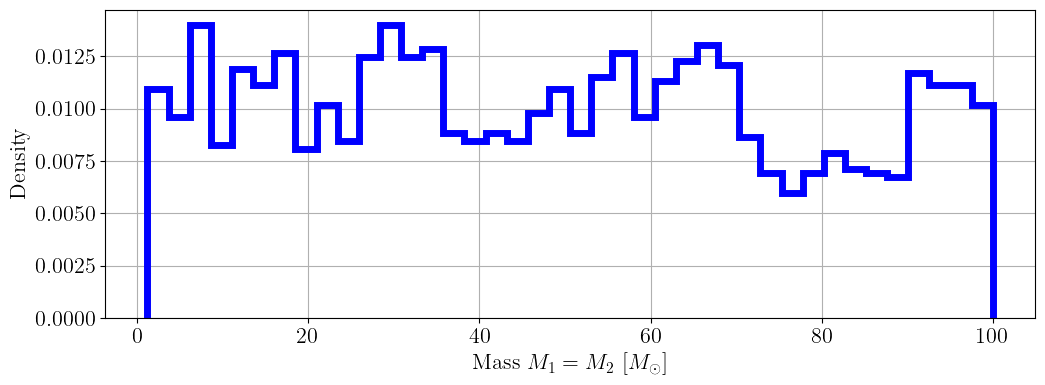

In [70]:
plt.figure(figsize = (12, 4))
plt.hist(m_nans, bins = 40, histtype='step', color="blue", linewidth=5, density=True)
plt.xlabel(r"Mass $M_1 = M_2$ [$M_{\odot}$]")
plt.ylabel(r"Density")
plt.show()